In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
data = pd.read_csv('secondhanddataset.csv')
data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [3]:
# Defining the categorical and numerical columns
categorical_cols = ['rating', 'condition']
numerical_cols = [col for col in data.columns if col not in ['current price'] + categorical_cols]

In [4]:
# Splitting into X and Y
X = data.drop(columns=['current price'])
y = data['current price'].values.reshape(-1, 1)

In [5]:
# Preprocessing categorical and numerical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)

In [6]:
# Scaling Target (y)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [7]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size=0.2, random_state=42)


In [8]:
# Converting to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

## Model Deeplearning Menggunakan PyTorch

In [9]:
# Build a PyTorch model
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.leaky_relu = nn.LeakyReLU()
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [24]:
# Training the model
model = PyTorchModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float("inf")
patience, counter = 50, 0

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


In [16]:
# Evaluate the model
y_pred_torch = model(X_test_torch).detach().numpy()
print("PyTorch MSE:", mean_squared_error(y_test, y_pred_torch))
print("PyTorch RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_torch)))
print("PyTorch R-Squared:", max(0, r2_score(y_test, y_pred_torch)))


PyTorch MSE: 0.01252896171791479
PyTorch RMSE: 0.11193284467891804
PyTorch R-Squared: 0.9881659422999325


## Model Deeplearning Menggunakan TensorFlow

In [39]:
# Build a TensorFlow model
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(optimizer='adam', loss='mse')
model_tf.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Evaluate the model
y_pred_tf = model.predict(X_test)
print("TensorFlow MSE:", mean_squared_error(y_test, y_pred_tf))
print("TensorFlow RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tf)))
print("TensorFlow R-Squared:", r2_score(y_test, y_pred_tf))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
TensorFlow MSE: 0.003873650412977089
TensorFlow RMSE: 0.06223865690209814
TensorFlow R-Squared: 0.9963411970178252


In [60]:
# Evaluate the model
model_tf.eval()
y_pred_torch = model(X_test_torch).detach().numpy()

AttributeError: 'Sequential' object has no attribute 'eval'

## Plotting

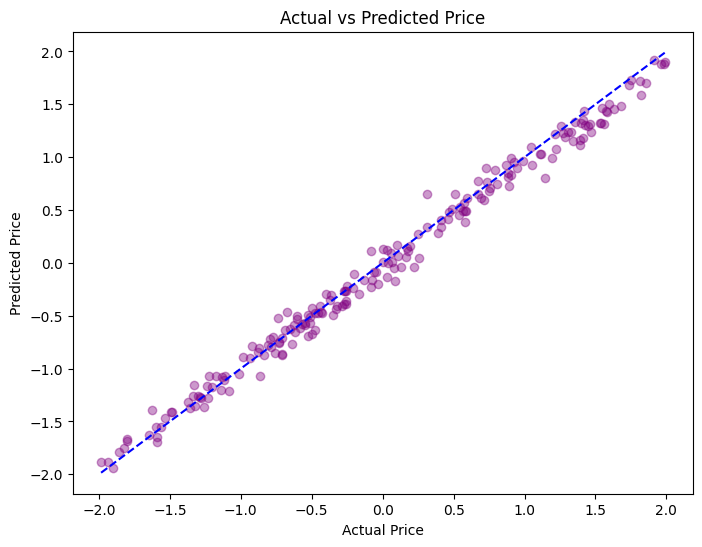

In [63]:
# Plot Predicted vs Actual price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_torch, alpha=0.4, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [64]:
# Prediksi dengan model TensorFlow
y_pred_tf = model_tf.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


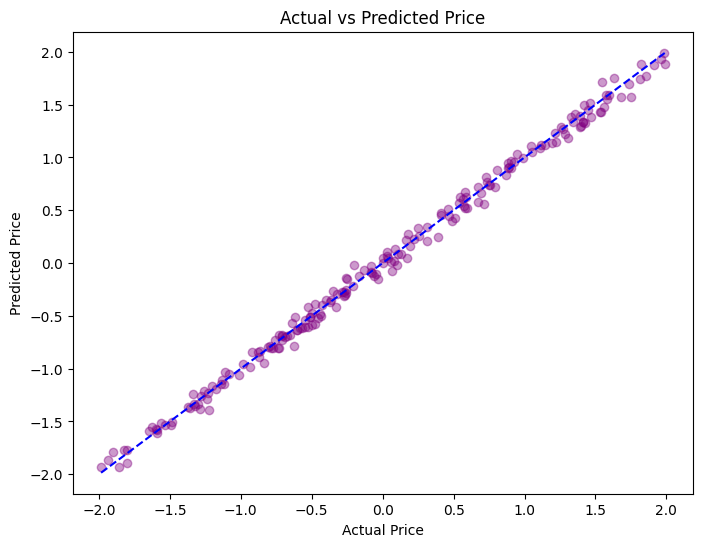

In [65]:
# Plot Predicted vs Actual price
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tf, alpha=0.4, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()